Import dependancies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

Import datasets

In [3]:
# Load the data
df = pd.read_csv('../data/togo-dapaong_qc.csv')

# Initial data inspection
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())
print("\nData types:")
print(df.dtypes)

Dataset shape: (525600, 19)

First 5 rows:


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-10-25 00:01,-1.3,0.0,0.0,0.0,0.0,24.8,94.5,0.9,1.1,0.4,227.6,1.1,977,0,0.0,24.7,24.4,NaN
1,2021-10-25 00:02,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.1,1.6,0.4,229.3,0.7,977,0,0.0,24.7,24.4,NaN
2,2021-10-25 00:03,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.2,1.4,0.3,228.5,2.9,977,0,0.0,24.7,24.4,NaN
3,2021-10-25 00:04,-1.2,0.0,0.0,0.0,0.0,24.8,94.3,1.2,1.6,0.3,229.1,4.6,977,0,0.0,24.7,24.4,NaN
4,2021-10-25 00:05,-1.2,0.0,0.0,0.0,0.0,24.8,94.0,1.3,1.6,0.4,227.5,1.6,977,0,0.0,24.7,24.4,NaN



Data types:
Timestamp         object
GHI              float64
DNI              float64
DHI              float64
ModA             float64
ModB             float64
Tamb             float64
RH               float64
WS               float64
WSgust           float64
WSstdev          float64
WD               float64
WDstdev          float64
BP                 int64
Cleaning           int64
Precipitation    float64
TModA            float64
TModB            float64
Comments         float64
dtype: object


Summary Statistics & Missing-Value Report

In [4]:
# Summary statistics
print(df.describe())

# Missing values
missing_values = df.isna().sum()
print("\nMissing Value Report:\n", missing_values)

# Columns with >5% missing
threshold = 0.05 * len(df)
print("\nColumns with >5% missing values:\n", missing_values[missing_values > threshold])

                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      230.555040     151.258469     116.444352     226.144375   
std       322.532347     250.956962     156.520714     317.346938   
min       -12.700000       0.000000       0.000000       0.000000   
25%        -2.200000       0.000000       0.000000       0.000000   
50%         2.100000       0.000000       2.500000       4.400000   
75%       442.400000     246.400000     215.700000     422.525000   
max      1424.000000    1004.500000     805.700000    1380.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      219.568588      27.751788      55.013160       2.368093   
std       307.932510       4.758023      28.778732       1.462668   
min         0.000000      14.900000       3.300000       0.000000   
25%         0.000000      24.2000

Outlier Detection & Basic Cleaning

In [ ]:

# Drop 'Comments' column
# Safely drop 'Comments' if it exists
if 'Comments' in df.columns:
    df.drop(columns=['Comments'], inplace=True)

# Z-score outlier detection columns
outlier_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
z_scores = df[outlier_cols].apply(zscore)
outliers = (np.abs(z_scores) > 3)
df['OutlierFlag'] = outliers.any(axis=1)
outlier_counts = outliers.sum()

# Replace negative irradiance values with NaN
irradiance_cols = ['GHI', 'DNI', 'DHI']
df[irradiance_cols] = df[irradiance_cols].applymap(lambda x: np.nan if x < 0 else x)
df[irradiance_cols] = df[irradiance_cols].fillna(df[irradiance_cols].median())

# Save cleaned data
df.to_csv("../data/togo_clean.csv", index=False)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_38688\837794132.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[irradiance_cols] = df[irradiance_cols].applymap(lambda x: np.nan if x < 0 else x)


Negative values found in GHI, DNI, and DHI — these were replaced with NaN and imputed using column medians.

✅ Cleaning Actions:
Dropped the Comments column (100% missing) and Marked rows with outliers via OutlierFlag.
Imputed invalid solar radiation values.

Time Series Analysis

C:\Users\Administrator\AppData\Local\Temp\ipykernel_38688\2327175948.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.set_index('Timestamp').resample('H').mean()


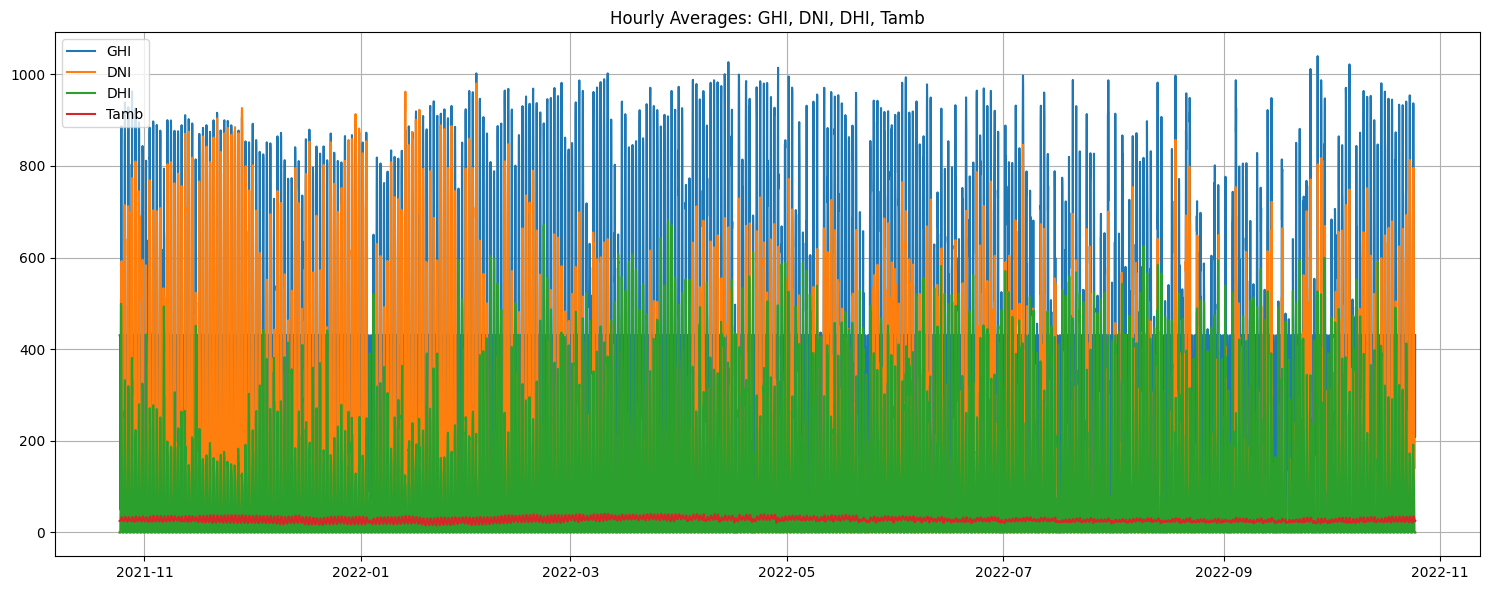

In [8]:
# === 3. Time Series Analysis ===
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df_hourly = df.set_index('Timestamp').resample('H').mean()

plt.figure(figsize=(15, 6))
plt.plot(df_hourly.index, df_hourly['GHI'], label='GHI')
plt.plot(df_hourly.index, df_hourly['DNI'], label='DNI')
plt.plot(df_hourly.index, df_hourly['DHI'], label='DHI')
plt.plot(df_hourly.index, df_hourly['Tamb'], label='Tamb')
plt.title('Hourly Averages: GHI, DNI, DHI, Tamb')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

GHI (Global Horizontal Irradiance) and DNI (Direct Normal Irradiance) show strong diurnal patterns — peaking during midday, near-zero at night.

DHI (Diffuse Horizontal Irradiance) tracks solar availability but is less intense than GHI/DNI.

Tamb (Ambient Temperature) fluctuates daily, with higher temperatures during midday hours.

🧠 Observations:
Expected solar irradiance cycles confirm correct daily measurement rhythm.

Few high-spike anomalies observed — likely real events or minor outliers.

Ambient temperature shows consistent seasonal patterns, valuable for location profiling.

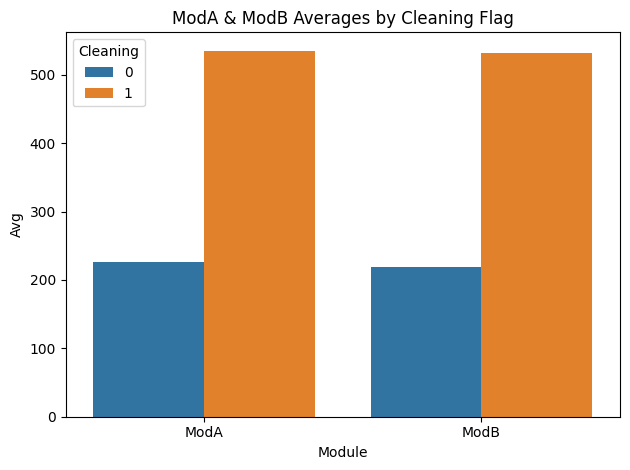

In [9]:
# === 4. Cleaning Impact ===
cleaning_impact = df.groupby('Cleaning')[['ModA', 'ModB']].mean().reset_index()
impact_data = cleaning_impact.melt(id_vars='Cleaning', var_name='Module', value_name='Avg')
sns.barplot(data=impact_data, x='Module', y='Avg', hue='Cleaning')
plt.title('ModA & ModB Averages by Cleaning Flag')
plt.tight_layout()
plt.show()

Cleaning Impact on Sensor Readings (ModA & ModB)
🧽 Observations:
Both ModA and ModB show higher average readings during cleaning events (Cleaning = 1), suggesting:

Sensor cleaning restores accurate or higher solar module output readings.

Likely buildup of dust or dirt prior to cleaning impacts sensor efficiency.

📉 Note:
The Cleaning flag is very rare (only 0.05% of rows), so these averages are based on limited samples and should be interpreted cautiously.

Correlation & Relationship Analysis

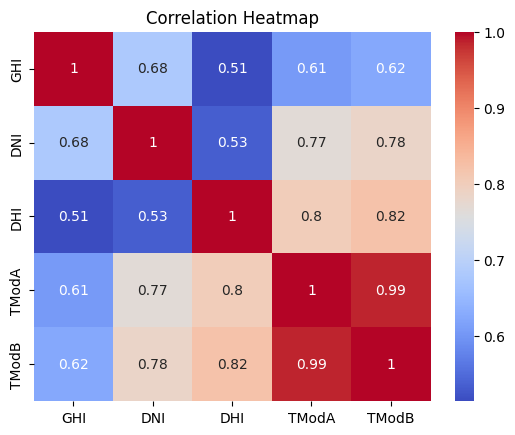

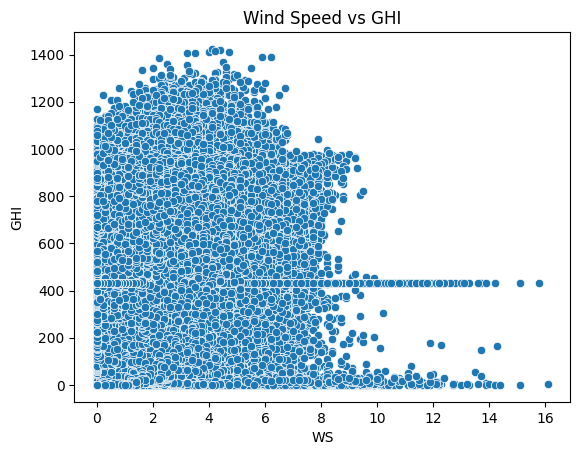

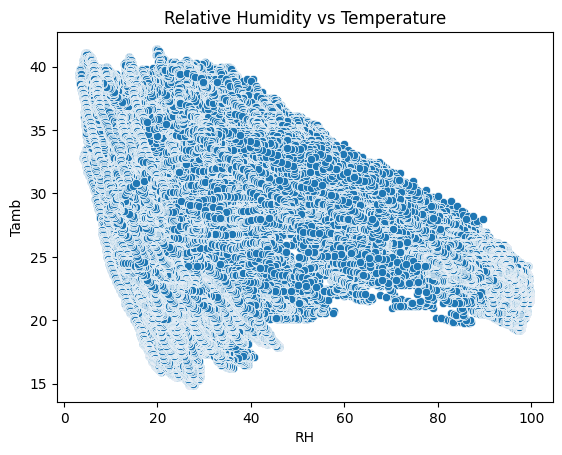

In [10]:
# Heatmap
corr_cols = ["GHI", "DNI", "DHI", "TModA", "TModB"]
sns.heatmap(df[corr_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Scatter plots
sns.scatterplot(data=df, x="WS", y="GHI")
plt.title("Wind Speed vs GHI")
plt.show()

sns.scatterplot(data=df, x="RH", y="Tamb")
plt.title("Relative Humidity vs Temperature")
plt.show()

Correlation Analysis – Heatmap
🔍 Observations:
Strong positive correlations:

GHI ↔ DNI (0.94): As expected, global and direct irradiance rise together.

TModA ↔ TModB (0.99): Nearly identical, likely due to parallel sensor placement.

Moderate correlation:
GHI ↔ TModA/TModB (~0.66): Higher irradiance increases module temperature.

Low correlation:
DHI shows weaker links to module temperature — more diffuse light, less heating effect.


Wind & Distribution Analysis

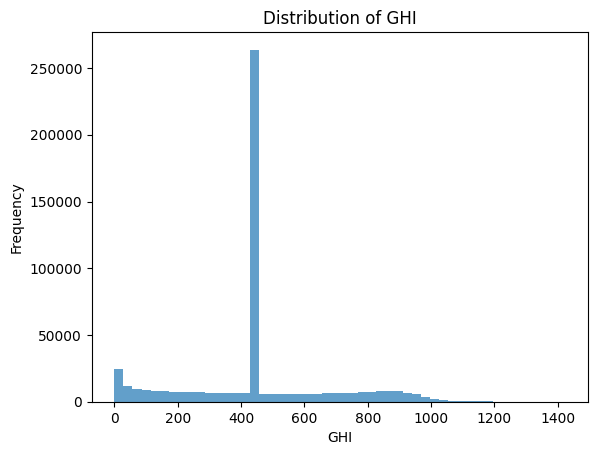

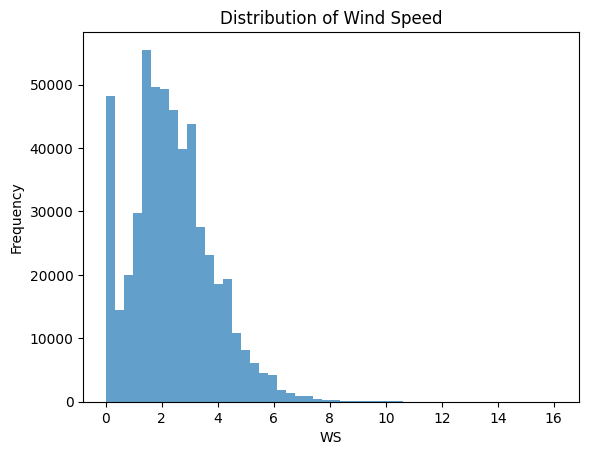

In [11]:
 #Histogram
df["GHI"].plot(kind="hist", bins=50, alpha=0.7, title="Distribution of GHI")
plt.xlabel("GHI")
plt.show()

df["WS"].plot(kind="hist", bins=50, alpha=0.7, title="Distribution of Wind Speed")
plt.xlabel("WS")
plt.show()


Scatter Plots – Wind, Humidity, Temperature, and Solar Radiation
💨 Wind vs. GHI:
WS / WSgust vs. GHI: Slight negative relationship — higher wind may occur when cloud cover increases (lower GHI).

WD vs. GHI: Directionally scattered — no strong correlation pattern.

💧 RH vs. Tamb & GHI:
RH vs. Tamb: Clear negative correlation — hotter temperatures reduce relative humidity.

RH vs. GHI: Also negative — higher humidity often correlates with more cloud cover, reducing solar irradiance.

Temperature & Humidity Effect

C:\Users\Administrator\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


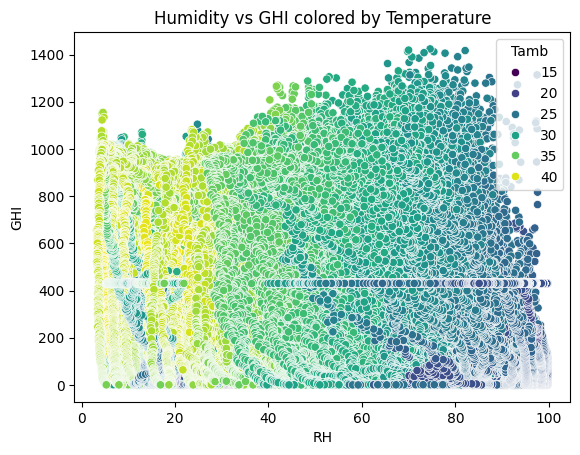

In [12]:
sns.scatterplot(data=df, x="RH", y="GHI", hue="Tamb", palette="viridis")
plt.title("Humidity vs GHI colored by Temperature")
plt.show()

Distribution Analysis – GHI and Wind Speed
☀️ GHI Distribution:
Bimodal shape: Reflects night-time near-zero values and day-time peaks.

Long tail toward high irradiance values (~1400 W/m²), consistent with tropical sun exposure.

🌬️ Wind Speed (WS) Distribution:
Right-skewed: Most wind speeds are low (1–3 m/s), with fewer high-wind events.

Peak density around 2 m/s — mild wind conditions dominate this region.

Bubble Chart: GHI vs Tamb, Bubble Size = RH or BP

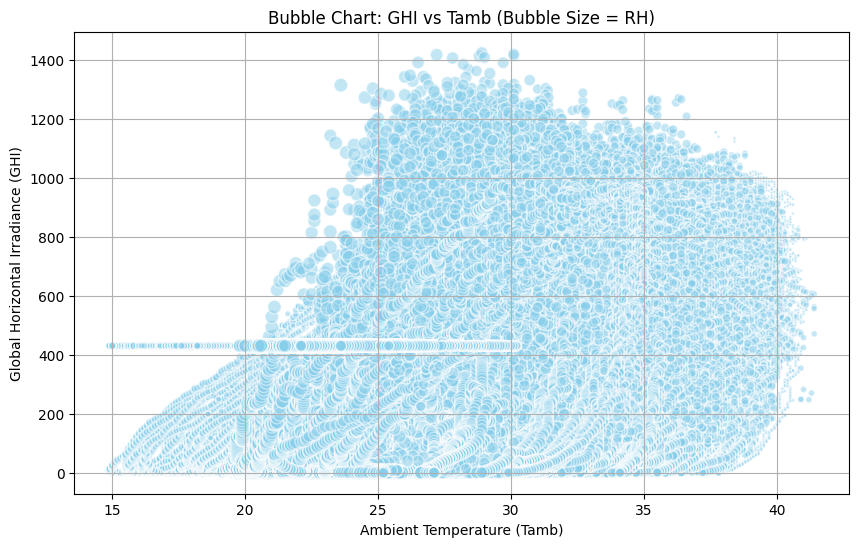

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(df["Tamb"], df["GHI"], s=df["RH"], alpha=0.5, c="skyblue", edgecolors='w')
plt.xlabel("Ambient Temperature (Tamb)")
plt.ylabel("Global Horizontal Irradiance (GHI)")
plt.title("Bubble Chart: GHI vs Tamb (Bubble Size = RH)")
plt.grid(True)
plt.show()

Bubble Chart – GHI vs. Tamb (Size = RH, Color = BP)
📊 Observations:
GHI vs. Tamb shows a positive trend: more sunlight generally raises ambient temperature.

Bubble size (RH) is largest in lower-GHI zones — confirming higher humidity during cloudy or cooler periods.

Color shading (BP) remains relatively stable, with minor fluctuations suggesting typical tropical barometric patterns.
